## Imports

In [1]:
!pip install thefuzz
!pip install thefuzz[speedup]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.4 MB/s eta 0:00:00


In [2]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import os

from thefuzz import process
from thefuzz import fuzz

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing IAM Dataset

In [4]:
base_path = "drive/MyDrive/NLP"
lines_list = []

lines = open(f"{base_path}/data/lines.txt", "r").readlines()
for line in lines:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        lines_list.append(line)

np.random.shuffle(lines_list)
len(lines_list)

11344

In [5]:
lines_aug_list = []

lines_aug = open(f"{base_path}/aug_data/line_new.txt", "r").readlines()
for line in lines_aug:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        lines_aug_list.append(line)

np.random.shuffle(lines_aug_list)
len(lines_aug_list)

13353

In [6]:
i=np.random.randint(len(lines_aug_list),size=(int(len(lines_aug_list)/2)))
lines_aug_list=np.delete(lines_aug_list,i)

## Data input pipeline

We start building our data input pipeline by first preparing the image paths.

In [7]:
# orignal data
base_image_path = os.path.join(base_path,"data" ,"lines")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

img_paths, labels = get_image_paths_and_labels(lines_list)

In [8]:
# augmented data
base_image_path = os.path.join(base_path,"aug_data" ,"aug_lines")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        base_image_path = os.path.join(base_path,"aug_data" ,"aug_lines")
        line_split=file_line.strip()
        line_split = line_split.split(" ")
        image_name=line_split[0]
        img_path = os.path.join(base_image_path, image_name)
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

img_paths_aug, labels_aug = get_image_paths_and_labels(lines_aug_list)

In [9]:
img_paths=np.array(img_paths+img_paths_aug)
labels=np.array(labels+labels_aug)

r_indexes = np.arange(len(img_paths))
np.random.shuffle(r_indexes)

img_paths=img_paths[r_indexes]
labels=labels[r_indexes]

len(img_paths)

19445

We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).

In [10]:
split_idx = int(0.6 * len(img_paths))

train_img_paths = img_paths[:split_idx]
train_labels= labels[:split_idx]

test_img_paths = img_paths[split_idx:]
test_labels=labels[split_idx:]

val_split_idx = int(0.5 * len(test_img_paths))

validation_img_paths = test_img_paths[:val_split_idx]
validation_labels= test_labels[:val_split_idx]

test_img_paths = test_img_paths[val_split_idx:]
test_labels= test_labels[val_split_idx:]


assert len(img_paths) == len(train_img_paths) + len(validation_img_paths) + len(test_img_paths)

print(f"Total training samples: {len(train_img_paths)}")
print(f"Total validation samples: {len(validation_img_paths)}")
print(f"Total test samples: {len(test_img_paths)}")

Total training samples: 11667
Total validation samples: 3889
Total test samples: 3889


Then we prepare the ground-truth labels.

In [11]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    label=label.replace("|"," ")
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  93
Vocab size:  79


['London new towns which cannot be filled',
 'the window . Went and consulted the driver .',
 'another impression that became more',
 "Throughout Mr. Macmillan's speech the Earl",
 'battle was no substitute for a sound policy ,',
 'Germany was breaking the agreement to stop',
 'agreed to give similar " facilities "',
 'to which her own had responded as it',
 'called " the going-out of the land of',
 'the diplomatist Lord Ponsonby , had written to advise']

Now we clean the validation and the test labels as well.

In [12]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        label=label.replace("|"," ")
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### Building the character vocabulary

Keras provides different preprocessing layers to deal with different modalities of data.
[This guide](https://keras.io/guides/preprocessing_layers/) provides a comprehensive introduction.
Our example involves preprocessing labels at the character
level. This means that if there are two labels, e.g. "cat" and "dog", then our character
vocabulary should be {a, c, d, g, o, t} (without any special tokens). We use the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/)
layer for this purpose.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

### Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become
clearer in a moment when we will visualize a few samples from the dataset. While
aspect-unaware resizing square images does not introduce a significant amount of
distortion this is not the case for rectangular images. But resizing images to a uniform
size is a requirement for mini-batching. So we need to perform our resizing such that
the following criteria are met:

* Aspect ratio is preserved.
* Content of the images is not affected.

In [14]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


### Putting the utilities together

In [15]:
batch_size = 24
padding_token = 99
image_width = 512
image_height = 128


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


## Prepare `tf.data.Dataset` objects

In [16]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## Visualize a few samples

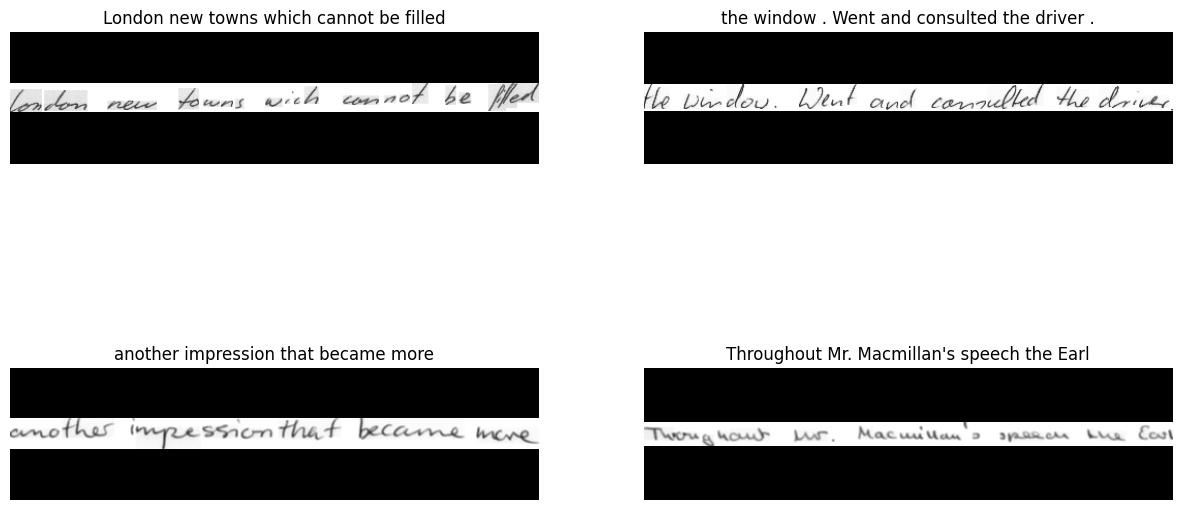

In [17]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(2, 2, figsize=(15, 8))

    for i in range(4):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 2, i % 2].imshow(img, cmap="gray")
        ax[i // 2, i % 2].set_title(label)
        ax[i // 2, i % 2].axis("off")


plt.show()

You will notice that the content of original image is kept as faithful as possible and has
been padded accordingly.

## Model

Our model will use the CTC loss as an endpoint layer. For a detailed understanding of the
CTC loss, refer to [this post](https://distill.pub/2017/ctc/).

In [18]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # Conv blocks
    x = keras.layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1",)(input_img)
    x = keras.layers.Conv2D(128,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2",)(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    x = keras.layers.Conv2D(256,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv3",)(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Conv2D(1024,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv4",)(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    x = keras.layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv5",)(x)
    
   
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(1024, return_sequences=True, dropout=0.3)
    )(x)
    
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(512, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.2)
    )(x)
    
    
    x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

## Training

Now we are ready to kick off model training.

In [ ]:
model = build_model()
# model.load_weights(base_path+"/handwriting.h5")
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 512, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 512, 128, 32  320         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 Conv2 (Conv2D)                 (None, 512, 128, 12  36992       ['Conv1[0][0]']                  
                                8)                                           

In [ ]:
# Train the model.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(base_path+"/handwriting.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',restore_best_weights=True)
epochs = 50

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb,early_stopping_cb],
)

Epoch 1/50
487/487 [==============================] - 958s 2s/step - loss: 136.8829 - val_loss: 134.6452
Epoch 2/50
487/487 [==============================] - 824s 2s/step - loss: 128.5890 - val_loss: 111.5986
Epoch 3/50
487/487 [==============================] - 807s 2s/step - loss: 96.2433 - val_loss: 77.2739
Epoch 4/50
487/487 [==============================] - 795s 2s/step - loss: 60.8386 - val_loss: 41.0620
Epoch 5/50
487/487 [==============================] - 789s 2s/step - loss: 36.6539 - val_loss: 28.3314
Epoch 6/50
487/487 [==============================] - 785s 2s/step - loss: 27.1818 - val_loss: 22.4209
Epoch 7/50
487/487 [==============================] - 784s 2s/step - loss: 22.2819 - val_loss: 19.5001
Epoch 8/50
487/487 [==============================] - 783s 2s/step - loss: 18.8037 - val_loss: 17.0796
Epoch 9/50
487/487 [==============================] - 784s 2s/step - loss: 16.3464 - val_loss: 15.4079
Epoch 10/50
487/487 [==============================] - 783s 2s/step -

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluation metric

[Edit Distance](https://en.wikipedia.org/wiki/Edit_distance)
is the most widely used metric for evaluating OCR models. In this section, we will
implement it and use it as a callback to monitor our model.

In [19]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

## Inference

In [20]:
model=build_model()
model.load_weights(base_path+"/handwriting.h5")
prediction_model = keras.models.Model(
     model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

len is :  2
batch img shape:  (512, 128, 1)
1/1 [==============================] - 20s 20s/step


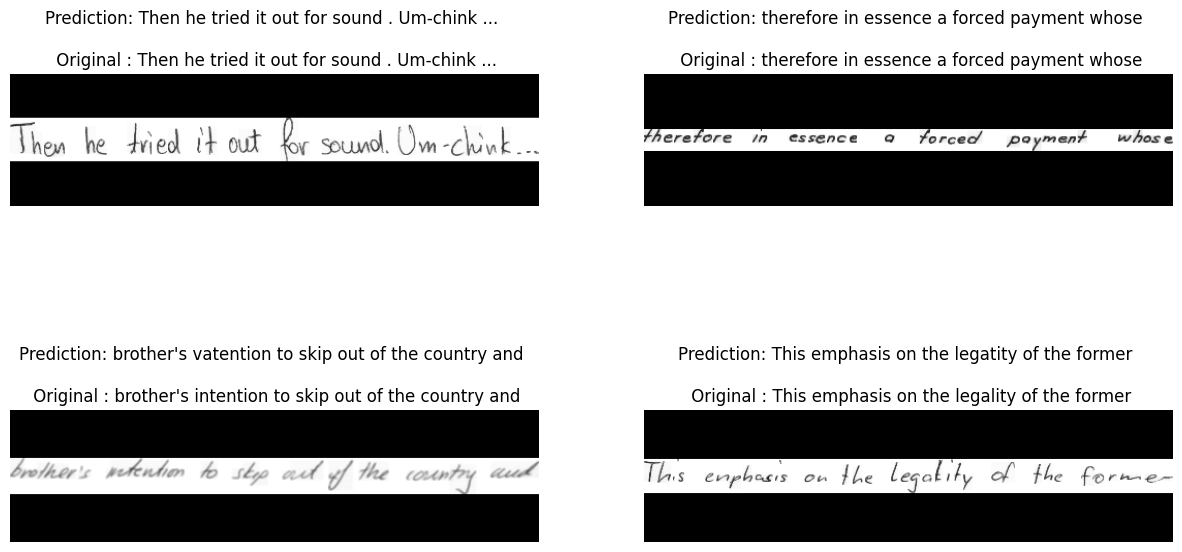

In [21]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    # print(batch["label"])
    batch_images,batch_labels = batch["image"],batch["label"]
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[1].shape)
    # print(batch)
    _, ax = plt.subplots(2, 2, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(4):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        ax[i // 2, i % 2].imshow(img, cmap="gray")
        ax[i // 2, i % 2].set_title(title)
        ax[i // 2, i % 2].axis("off")

plt.show()

In [22]:
# Edit Distance

ed_sum = 0
count=0

for batch in test_ds.take(len(test_img_paths)//batch_size + 1):
    batch_images,batch_labels = batch["image"],batch["label"]

    preds = model.predict(batch)
    ed_sum+=calculate_edit_distance(batch_labels,preds)
    count+=1


print("\nEdit Distance : ",ed_sum/count)

1/1 [==============================] - 1s 747ms/step

Edit Distance :  tf.Tensor(52.91131, shape=(), dtype=float32)


In [23]:
img_path = base_path+'/test-img1.png'
def prepare_dataset_custom(img_paths_3):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths_3)).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)
img_paths_3 = [img_path]
custom_ds = prepare_dataset_custom(img_paths_3)

len is :  1
batch img shape:  (512, 128, 1)
1/1 [==============================] - 0s 61ms/step
['1. montairne .']


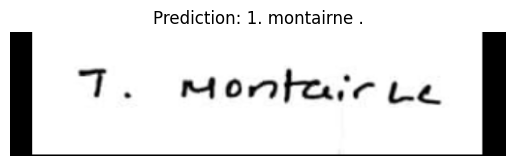

In [24]:
for batch in custom_ds.take(1):
    print("len is : ",len(batch))
    print("batch img shape: ",batch[0].shape)

    preds = prediction_model.predict(batch)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)

    for i in range(1):
        img = batch[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        plt.imshow(img, cmap="gray")
        plt.title(title)
        plt.axis("off")

plt.show()

## Fine Tuning

### Import data and preprocessing

In [33]:
df=pd.read_csv(base_path+"/custom_data/annot.csv")
df_aug=pd.read_csv(base_path+"/custom_data/annot1.csv")

df=pd.concat([df,df_aug])
df = df.sample(frac = 1,ignore_index=True)
df.head()

,images,label
0,cust_aug_66_1.png,Aciloc 150
1,cust_aug_135_1.png,T. Nexpro RD
2,cust_aug_121_3.png,Tab Wikoryl
3,cust_aug_133_1.png,Cap Panroc DSR
4,cust_aug_65_3.png,Tab Zerodol - SP


In [34]:
data_path=base_path+"/custom_data/images/"
def get_paths(x):
  return data_path+x

df['images']=df['images'].apply(lambda x:get_paths(x))
df.head()

,images,label
0,drive/MyDrive/NLP/custom_data/images/cust_aug_...,Aciloc 150
1,drive/MyDrive/NLP/custom_data/images/cust_aug_...,T. Nexpro RD
2,drive/MyDrive/NLP/custom_data/images/cust_aug_...,Tab Wikoryl
3,drive/MyDrive/NLP/custom_data/images/cust_aug_...,Cap Panroc DSR
4,drive/MyDrive/NLP/custom_data/images/cust_aug_...,Tab Zerodol - SP


In [35]:
X_train,X_test,y_train,y_test=train_test_split(df['images'],df['label'],test_size=0.2)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5)

print("Training Size:",len(X_train))
print("Validation Size:",len(X_val))
print("Testing Size:",len(X_test))

Training Size: 612
Validation Size: 76
Testing Size: 77


In [36]:
train_ds = prepare_dataset(X_train, y_train)
validation_ds = prepare_dataset(X_val, y_val)
test_ds = prepare_dataset(X_test, y_test)

### Visualize Data

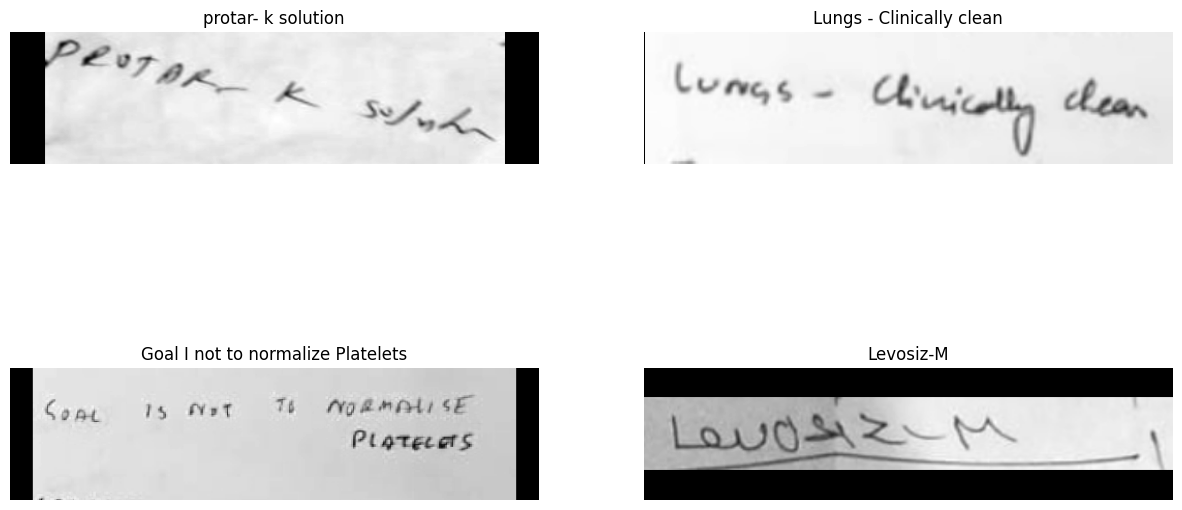

In [37]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(2, 2, figsize=(15, 8))

    for i in range(4):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 2, i % 2].imshow(img, cmap="gray")
        ax[i // 2, i % 2].set_title(label)
        ax[i // 2, i % 2].axis("off")


plt.show()

### Fine Tuning

In [38]:
model=build_model()
model.load_weights(base_path+"/handwriting.h5")

In [39]:
# Train the model.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(base_path+"/fine_tuned.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',restore_best_weights=True)
epochs = 50 

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[early_stopping_cb,checkpoint_cb],
)

Epoch 1/50
26/26 [==============================] - 127s 3s/step - loss: 51.1537 - val_loss: 36.3087
Epoch 2/50
26/26 [==============================] - 41s 2s/step - loss: 32.6728 - val_loss: 29.0623
Epoch 3/50
26/26 [==============================] - 40s 2s/step - loss: 24.5435 - val_loss: 22.3402
Epoch 4/50
26/26 [==============================] - 40s 2s/step - loss: 18.5213 - val_loss: 17.3834
Epoch 5/50
26/26 [==============================] - 40s 2s/step - loss: 13.6691 - val_loss: 13.3302
Epoch 6/50
26/26 [==============================] - 40s 2s/step - loss: 10.3294 - val_loss: 10.8133
Epoch 7/50
26/26 [==============================] - 40s 2s/step - loss: 7.5678 - val_loss: 8.7841
Epoch 8/50
26/26 [==============================] - 40s 2s/step - loss: 5.8300 - val_loss: 6.8802
Epoch 9/50
26/26 [==============================] - 40s 2s/step - loss: 4.6308 - val_loss: 4.7091
Epoch 10/50
26/26 [==============================] - 40s 2s/step - loss: 3.4605 - val_loss: 4.5133
Epoch 

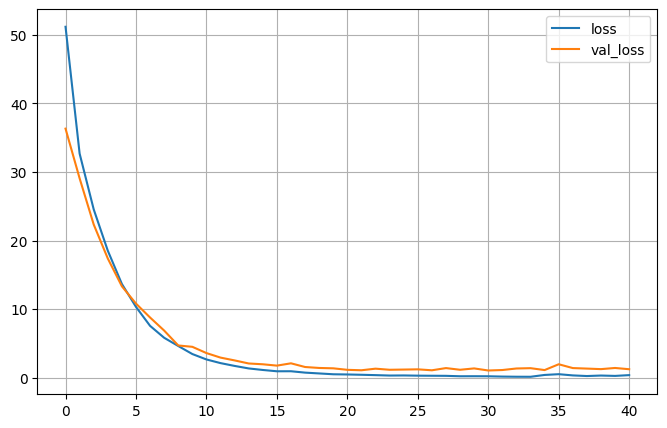

In [42]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

### Evaluation

In [43]:
model=build_model()
model.load_weights(base_path+"/fine_tuned.h5")

In [44]:
prediction_model = keras.models.Model(
     model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

len is :  2
batch img shape:  (512, 128, 1)
1/1 [==============================] - 2s 2s/step


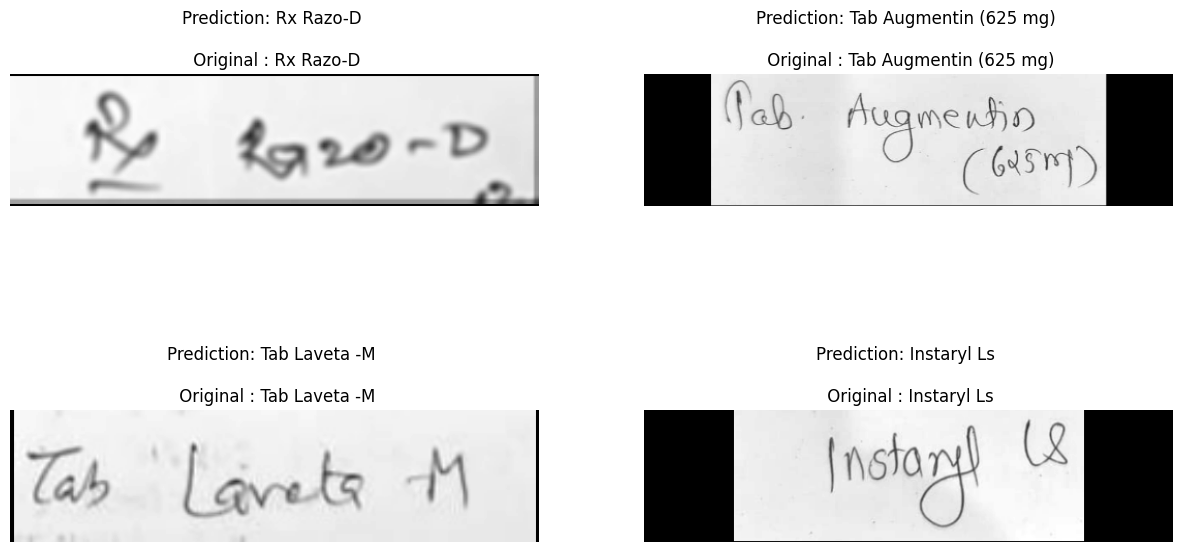

In [45]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    # print(batch["label"])
    batch_images,batch_labels = batch["image"],batch["label"]
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[1].shape)
    # print(batch)
    _, ax = plt.subplots(2, 2, figsize=(15, 8))

    preds = model.predict(batch)
    pred_texts = decode_batch_predictions(preds)

    for i in range(4):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        ax[i // 2, i % 2].imshow(img, cmap="gray")
        ax[i // 2, i % 2].set_title(title)
        ax[i // 2, i % 2].axis("off")

plt.show()

In [46]:
ed_sum = 0
count=0

for batch in test_ds.take(len(X_test)//batch_size + 1):
    batch_images,batch_labels = batch["image"],batch["label"]

    preds = model.predict(batch)
    ed_sum+=calculate_edit_distance(batch_labels,preds)
    count+=1


print("\nEdit Distance : ",ed_sum/count)

1/1 [==============================] - 3s 3s/step

Edit Distance :  tf.Tensor(78.33125, shape=(), dtype=float32)


## Predictions

In [47]:
df_med=pd.read_csv(base_path+"/medicines.csv")
df_med.drop('id',axis=1,inplace=True)

In [48]:
def prepare_dataset_custom(img_paths_3):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths_3)).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

def make_pred(img_path):
  img_paths = [img_path]
  custom_ds = prepare_dataset_custom(img_paths)
  for batch in custom_ds.take(1):
    preds = prediction_model.predict(batch)
    pred_texts = decode_batch_predictions(preds)

    img = batch[0]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"Prediction: {pred_texts[0]}"
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")

  plt.show()
  return pred_texts[0]

In [69]:
def extract_medicine_info(pred_texts):
  collection = df_med['name']
  med=process.extract(pred_texts, collection, scorer=fuzz.token_sort_ratio)
  med=med[0]
  if med[1]<80:
    print("Medicine not found")
  else:
    print(df_med.iloc[med[2]])
    return df_med.iloc[med[2]].to_dict()

1/1 [==============================] - 0s 81ms/step


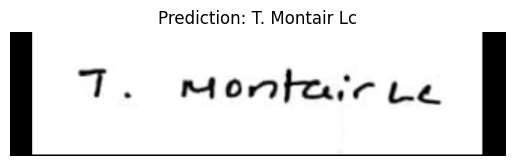

name                      Montair-LC Tablet
price(₹)                              336.0
Is_discontinued                       False
manufacturer_name                 Cipla Ltd
type                              allopathy
pack_size_label         strip of 15 tablets
short_composition1    Levocetirizine (5mg) 
short_composition2       Montelukast (10mg)
Name: 133367, dtype: object
1/1 [==============================] - 0s 81ms/step


In [70]:
# Test Image 1
img_path1 = base_path+'/test-img1.png'
pred_texts1=make_pred(img_path1)
medicine1=extract_medicine_info(pred_texts1)

In [72]:
print(medicine1)

{'name': 'Montair-LC Tablet', 'price(₹)': 336.0, 'Is_discontinued': False, 'manufacturer_name': 'Cipla Ltd', 'type': 'allopathy', 'pack_size_label': 'strip of 15 tablets', 'short_composition1': 'Levocetirizine (5mg) ', 'short_composition2': ' Montelukast (10mg)'}


1/1 [==============================] - 0s 90ms/step


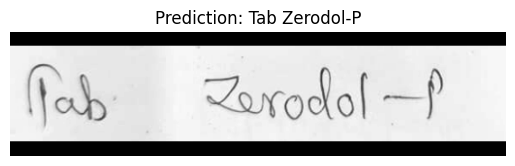

name                       Zerodol-P Tablet
price(₹)                               60.4
Is_discontinued                       False
manufacturer_name     Ipca Laboratories Ltd
type                              allopathy
pack_size_label         strip of 10 tablets
short_composition1     Aceclofenac (100mg) 
short_composition2      Paracetamol (325mg)
Name: 246379, dtype: object


In [73]:
# Test Image 2
img_path2 = base_path+'/test-img2.png'
pred_texts2=make_pred(img_path2)
medicine2=extract_medicine_info(pred_texts2)

In [74]:
print(medicine2)

{'name': 'Zerodol-P Tablet', 'price(₹)': 60.4, 'Is_discontinued': False, 'manufacturer_name': 'Ipca Laboratories Ltd', 'type': 'allopathy', 'pack_size_label': 'strip of 10 tablets', 'short_composition1': 'Aceclofenac (100mg) ', 'short_composition2': ' Paracetamol (325mg)'}


1/1 [==============================] - 0s 82ms/step


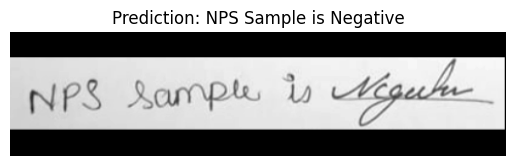

Medicine not found


In [75]:
# Test Image 3
img_path3 = base_path+'/test-img3.png'
pred_texts3=make_pred(img_path3)
medicine3=extract_medicine_info(pred_texts3)

In [76]:
print(medicine3)

None
